In [1]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from nlinec import get_models_dir, color_palette, gpartconv1d, get_all_types, get_granularity, get_results_dir

In [3]:
gran_types = []
for i in [1, 2, 3]:
    all_types = get_all_types(granularity=i)
    all_types['granularity'] = all_types['full_type'].apply(lambda x: get_granularity(x))
    gran_types.append(all_types[all_types['granularity'] == i])

In [4]:
def create_history_plot(model, granularity):
    # Read the 'accuracy.json' and 'loss.json' files in the model directory
    with open(os.path.join(get_models_dir(), model, 'accuracy.json'), 'r') as f:
        accuracy = pd.DataFrame(json.load(f), index=['accuracy']).T
        accuracy['step'] = accuracy.index
        accuracy['step'] = accuracy['step'].astype(int)

    with open(os.path.join(get_models_dir(), model, 'loss.json'), 'r') as f:
        loss = pd.DataFrame(json.load(f))
        loss['step'] = loss['step'].astype(int)

    sigma = min(2 * np.log(len(loss)), len(loss))
    loss['loss_smooth'] = gpartconv1d(loss['loss'], sigma=sigma)

    fig, ax = plt.subplots(1, 1, figsize=(5, 2), dpi=200)
    ax.set_xlabel('Training Step')
    ax.set_ylabel('Accuracy')

    ax.scatter(accuracy.step, accuracy['accuracy'], color=color_palette('medium'), s=5, zorder=3)
    ax.plot(accuracy.step, accuracy['accuracy'], label='Dev Accuracy', color=color_palette('medium'), zorder=3)

    ax.axhline(1/len(gran_types[granularity - 1]['full_type'].unique()), color=color_palette('accent'), linestyle='--', label='Random Guessing Accuracy')

    ax.set_ylim(0, 1)
    ax.set_xlim(0.8, max(accuracy.step) / 0.8)

    ax2 = ax.twinx()
    ax2.set_ylabel('Loss', color=color_palette('light'))
    ax2.plot(loss.step, loss['loss_smooth'], label='Loss', color=color_palette('light'))
    ax2.plot(loss.step, loss['loss'], color=color_palette('light'), alpha=0.2)

    ax2.set_ylim(0, None)

    # Add the loss from the ax2 to the ax legend
    handles1, labels1 = ax.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()

    ax2.legend(handles1 + handles2, labels1 + labels2, loc='upper left')

    ax.grid(axis='y', alpha=0.5)
    ax.set_xscale('log')

    fig.savefig(os.path.join(get_results_dir(), f'{model}', 'train_history.png'), bbox_inches='tight')

    return fig, ax

In [5]:
models = os.listdir(get_models_dir())
granularities = [int(models.split('-')[-1]) for models in models]
print(models, granularities)

['nlinec-E-2', 'nlinec-C-2', 'nlinec-D-1', 'nlinec-D-2', 'nlinec-D-3'] [2, 2, 1, 2, 3]


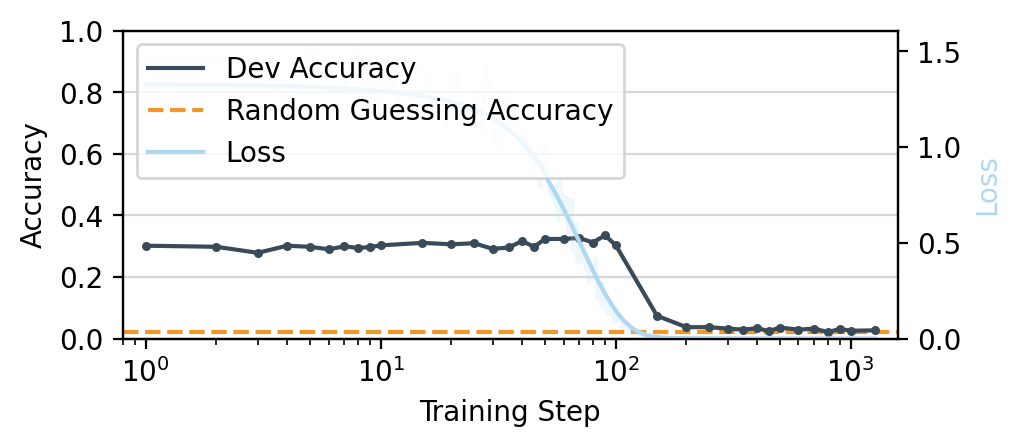

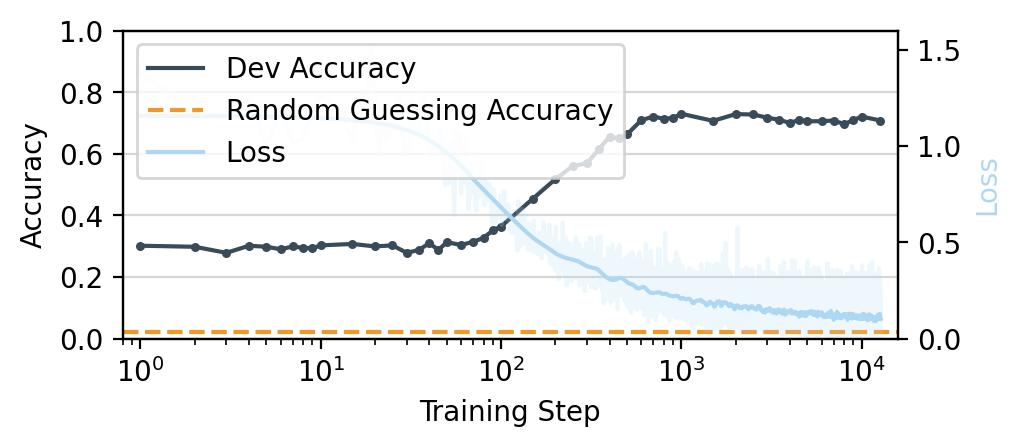

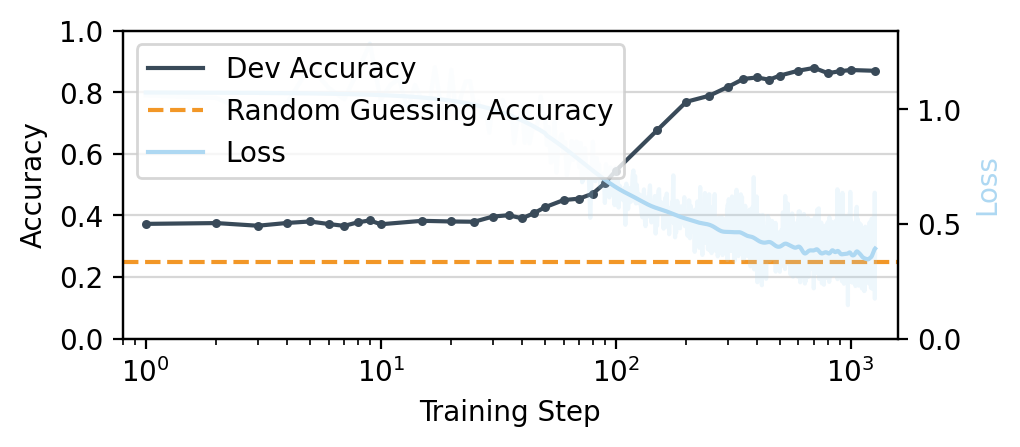

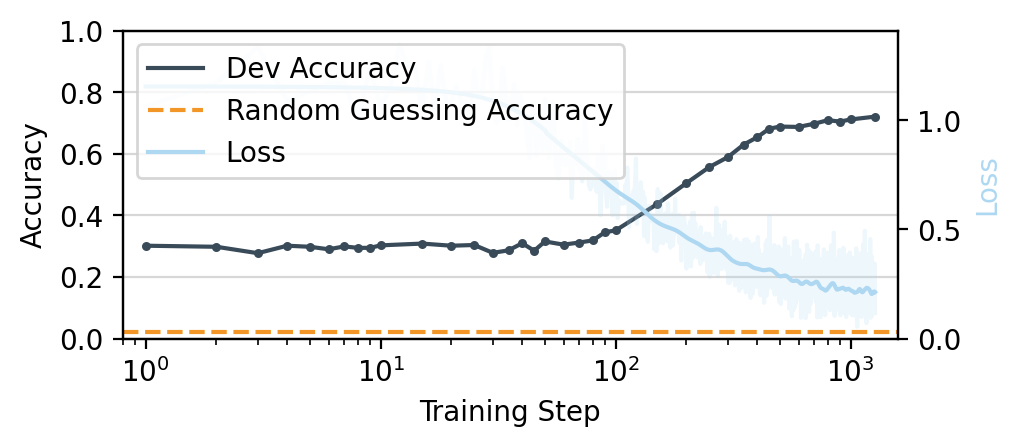

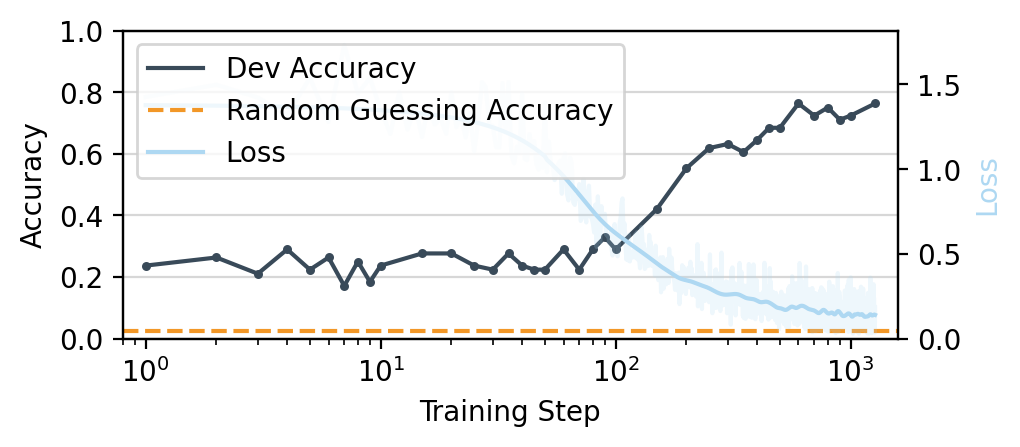

In [6]:
for model, granularities in zip(models, granularities):
    fig, ax = create_history_plot(model, granularities)
    plt.show()